In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.special import lambertw
from unbalancedsinkhorn import DebiasedUOT
from scipy import optimize
import torch
import pykeops as pykeops

## OT solution (Lambert-w method)

In [2]:
epsilon = 0.05
f = 1.0
g = 0.1 
a = 0.1 
b = 10.0
c = 0.5
d = 1.0
tol = 1e-12

# Decide on parameters
n1 = int(1 / epsilon) 
m1 = int(1 / epsilon)

# Assigning uniform weighting to points - Lloyde type
def height_func(x):
    return a * np.tanh(b * (x - c)) + d

# integral of tanh is ln(cosh) so;
def int_h(x):
    return a * np.log(np.cosh(b * (x - c)) / np.cosh(-b * c)) / b + d*x

# find X_j s.t. universe weighting is 1/N
X_j = np.zeros(n1)
for k, uk in enumerate(
    d*np.linspace(1 / (2 * n1), 1 - 1 / (2 * n1), n1, endpoint=True)
):
    X_j[k] = optimize.root(lambda x: int_h(x) - uk, x0=0).x[0]

# Calculate nabla P: x + f^2 * g * partial h
G_i = X_j + f**2 * g * a * b * (1 - np.tanh(b * (X_j - c)) ** 2)

# Meshes
# Regular grid
X = torch.linspace(1 / (2 * m1), 1 - 1 / (2 * m1), m1)

# llody fit grid
Y = torch.Tensor(X_j)

# Geo verse grid
G = torch.Tensor(G_i)

# Measures
h_true = height_func(X)
μ = torch.ones(m1) * d  / m1
σ = torch.ones(n1) * d  / n1

M = int(1 / epsilon**2)
X_dense = torch.linspace(1 / (2 * M), 1 - 1 / (2 * M), M)
h_dense = height_func(X_dense).view(-1, 1)


# Initialise Potnetials and cost function
ψ, φ = np.zeros(m1, dtype=np.float64), np.zeros(n1, dtype=np.float64)
cost = 0.5*f**2*cdist(G.reshape(-1, 1), X.reshape(-1,1))**2

In [55]:
def numpy_biased_ot(φ, ψ, cost, σ, μ):
    # Iterativ process
    kmax = int(-1.5 / epsilon * np.log(epsilon))
    
    for k in range(kmax):
        φ_temp, ψ_temp = φ.copy(), ψ.copy()
        φ = - epsilon * np.log(np.einsum('ij,j->i', np.exp((ψ[np.newaxis, :] - cost)/epsilon), μ))
        ψ = - epsilon * lambertw(g *(np.einsum('ij,i->j', np.exp((φ[:, np.newaxis] - cost)/epsilon), σ)) / epsilon,k=0).real

        err = max([np.linalg.norm(φ_temp - φ, ord=float('inf')), np.linalg.norm(ψ_temp - ψ, ord=float('inf'))])
        if err < tol:
            print(f'Broke at iter {k} of {kmax} with err {err}')
            break

    print(f'Final err {err}')

    return φ, ψ, - ψ / g

In [56]:
φ, ψ, h_recon = numpy_biased_ot(φ, ψ, cost, σ, μ)
R = np.outer(σ, μ)

π_1 = np.einsum('ij,ij->j',np.exp((φ[:, np.newaxis] + ψ[np.newaxis, :] - cost)/epsilon), R)
# Sanity check
(h_recon / π_1)

Broke at iter 61 of 89 with err 7.528422329983187e-13
Final err 7.528422329983187e-13


array([19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961])

In [57]:
def numpy_debiased_se(φ, ψ, φ_s, ψ_s, cost, φ_cost, ψ_cost, σ, μ):
    # Iterativ process
    kmax = int(-1.5 / epsilon * np.log(epsilon))

    for k in range(kmax):
        φ_temp, ψ_temp = φ.copy(), ψ.copy()
        φ_s_temp, ψ_s_temp = φ_s.copy(), ψ_s.copy()
        φ = - epsilon * np.log(np.einsum('ij,j->i', np.exp((ψ[np.newaxis, :] - cost)/epsilon), μ))
        ψ = ψ_s - epsilon * lambertw(g * np.exp(ψ_s /epsilon)*(np.einsum('ij,i->j', np.exp((φ[:, np.newaxis] - cost)/epsilon), σ)) /epsilon,k=0).real
        
        # Lod-Sum-Ratio
        ψ_s =  ψ + epsilon * np.log(np.einsum('ij,i->j', np.exp((φ[:, np.newaxis] - cost)/epsilon), σ)) - epsilon * np.log(np.einsum('ij,j->i', np.exp((ψ_s[np.newaxis, :] - ψ_cost)/epsilon), μ))
        
        # Symmetric decoupled update
        φ_s = 0.5*(φ_s - epsilon * np.log(np.einsum('ij,j->i', np.exp((φ_s[np.newaxis, :] - φ_cost)/epsilon), σ)))

        err = max([np.linalg.norm(φ_temp - φ, ord=float('inf')), np.linalg.norm(ψ_temp - ψ, ord=float('inf'))])
        err = max([err, np.linalg.norm(φ_s_temp - φ_s, ord=float('inf')), np.linalg.norm(ψ_s_temp - ψ_s, ord=float('inf'))])

        if err < tol:
            print(f'Broke at iter {k} of {kmax} with err {err}')
            break
    
    print(f'Final err {err}')
    return φ, ψ, φ_s, ψ_s, (ψ_s - ψ) / g

In [58]:
def Sinkhorn_Divergence_balanced(X, α, Y, β):
    uotclass = DebiasedUOT(pykeops=True)
    uotclass.parameters(epsilon=0.003125)
    uotclass.densities(X, Y, α, β)
    uotclass.sinkhorn_algorithm(aprox='balanced', tol=1e-14)
    return uotclass.sinkhorn_divergence(force_type='pykeops', return_type='primal')

In [59]:
φ_cost = 0.5*f**2*cdist(G.reshape(-1, 1), G.reshape(-1,1))**2
ψ_cost = 0.5*f**2*cdist(X.reshape(-1, 1), X.reshape(-1,1))**2
φ_s, ψ_s = np.zeros(n1, dtype=np.float64), np.zeros(m1, dtype=np.float64)
φ, ψ, φ_s, ψ_s, h_recon = numpy_debiased_se(φ, ψ, φ_s, ψ_s, cost, φ_cost, ψ_cost, σ, μ)
π_1 = np.einsum('ij,ij->j',np.exp((φ[:, np.newaxis] + ψ[np.newaxis, :] - cost)/epsilon), np.outer(σ, μ))
π_0 = np.einsum('ij,ij->i',np.exp((φ[:, np.newaxis] + ψ[np.newaxis, :] - cost)/epsilon), np.outer(σ, μ))

# Sanity check for finishing on this update
(h_recon / π_1)

Broke at iter 46 of 89 with err 9.046721705097127e-13
Final err 9.046721705097127e-13


array([19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961,
       19.99999961, 19.99999961, 19.99999961, 19.99999961, 19.99999961])

In [60]:
π_1.sum(), π_0.sum()

(1.000000023282635, 1.0000000232826347)

# Plotting

In [61]:
φ_de, ψ_de, φ_s, ψ_s, h_recon_debiased = numpy_debiased_se(φ, ψ, φ_s, ψ_s, cost, φ_cost, ψ_cost, σ, μ)
φ_b, ψ_b, h_recon_biased = numpy_biased_ot(φ, ψ, cost, σ, μ)

Broke at iter 0 of 89 with err 5.883626919001017e-13
Final err 5.883626919001017e-13
Broke at iter 57 of 89 with err 9.859613125939859e-13
Final err 9.859613125939859e-13


#### Bukld Barycentres

Do I divide the approximate marginals or the known sigma?

In [62]:
π_1 = np.einsum('ij,ij->j',np.exp((φ_de[:, np.newaxis] + ψ_de[np.newaxis, :] - cost)/epsilon), np.outer(σ, μ))
π_0 = np.einsum('ij,ij->i',np.exp((φ_de[:, np.newaxis] + ψ_de[np.newaxis, :] - cost)/epsilon), np.outer(σ, μ))
π_s_0 = np.einsum('ij,ij->i',np.exp((φ_s[:, np.newaxis] + φ_s[np.newaxis, :] - φ_cost)/epsilon), np.outer(σ, σ))

X_tilde = np.einsum('ij,ij,j->i',np.exp((φ_de[:, np.newaxis] + ψ_de[np.newaxis, :] - cost)/epsilon), np.outer(σ, μ), X) / π_0 
X_s_tilde = np.einsum('ij,ij,j->i',np.exp((φ_s[:, np.newaxis] + φ_s[np.newaxis, :] - φ_cost)/epsilon), np.outer(σ, σ),G) / π_s_0
X_debiased_tilde = X_tilde - (X_s_tilde - G.numpy())

In [63]:
s_debiased = Sinkhorn_Divergence_balanced(np.stack((X_dense, np.zeros(len(X_dense))), axis=-1), h_dense / len(h_dense) , np.stack((X, np.zeros(len(X))), axis=-1), h_recon_debiased/ len(h_recon_debiased))
s_bias = Sinkhorn_Divergence_balanced(np.stack((X_dense, np.zeros(len(X_dense))), axis=-1), h_dense/ len(h_dense), np.stack((X, np.zeros(len(X))), axis=-1), h_recon_biased/ len(h_recon_biased))
s_y = Sinkhorn_Divergence_balanced(np.stack((X_dense, np.zeros(len(X_dense))), axis=-1), h_dense/ len(h_dense), np.stack((Y, np.zeros(len(Y))), axis=-1), np.ones_like(Y) / len(Y))
s_X_bias = Sinkhorn_Divergence_balanced(np.stack((X_dense, np.zeros(len(X_dense))), axis=-1), h_dense/ len(h_dense), np.stack((X_tilde, np.zeros(len(X_tilde))), axis=-1), np.ones_like(X_tilde) / len(X_tilde))
s_X_debiased = Sinkhorn_Divergence_balanced(np.stack((X_dense, np.zeros(len(X_dense))), axis=-1), h_dense/ len(h_dense), np.stack((X_debiased_tilde, np.zeros(len(X_debiased_tilde))), axis=-1), np.ones_like(X_debiased_tilde) / len(X_debiased_tilde))


Convergence in f, g updates below 1e-14 in 655 iterations
Convergence in f, g updates below 1e-14 in 654 iterations
Convergence in f, g updates below 1e-14 in 655 iterations
Convergence in f, g updates below 1e-14 in 614 iterations


/home/jacob/PhD_code/flipflop/flipflop/flipflop.py:39: UserWarning: Convergence has completely plateaued
  warnings.warn(


Convergence in f, g updates below 1e-14 in 655 iterations
Convergence in f, g updates below 1e-14 in 654 iterations
Convergence in f, g updates below 1e-14 in 655 iterations
Convergence in f, g updates below 1e-14 in 615 iterations
Convergence in f, g updates below 1e-14 in 655 iterations
Convergence in f, g updates below 1e-14 in 753 iterations


Text(0.5, 1.1, 'W(dense, debaised_reconstruction) = 3.2585471854775644e-05,\n W(dense, baised_reconstruction) = 1.4777110885350074e-06, \n W(dense, llody) = 2.933003928977601e-07, \n W(dense, X tilde bias) = 0.0028141244840708176,\n W(X, X tilde debias) = 0.00015858059395827684')

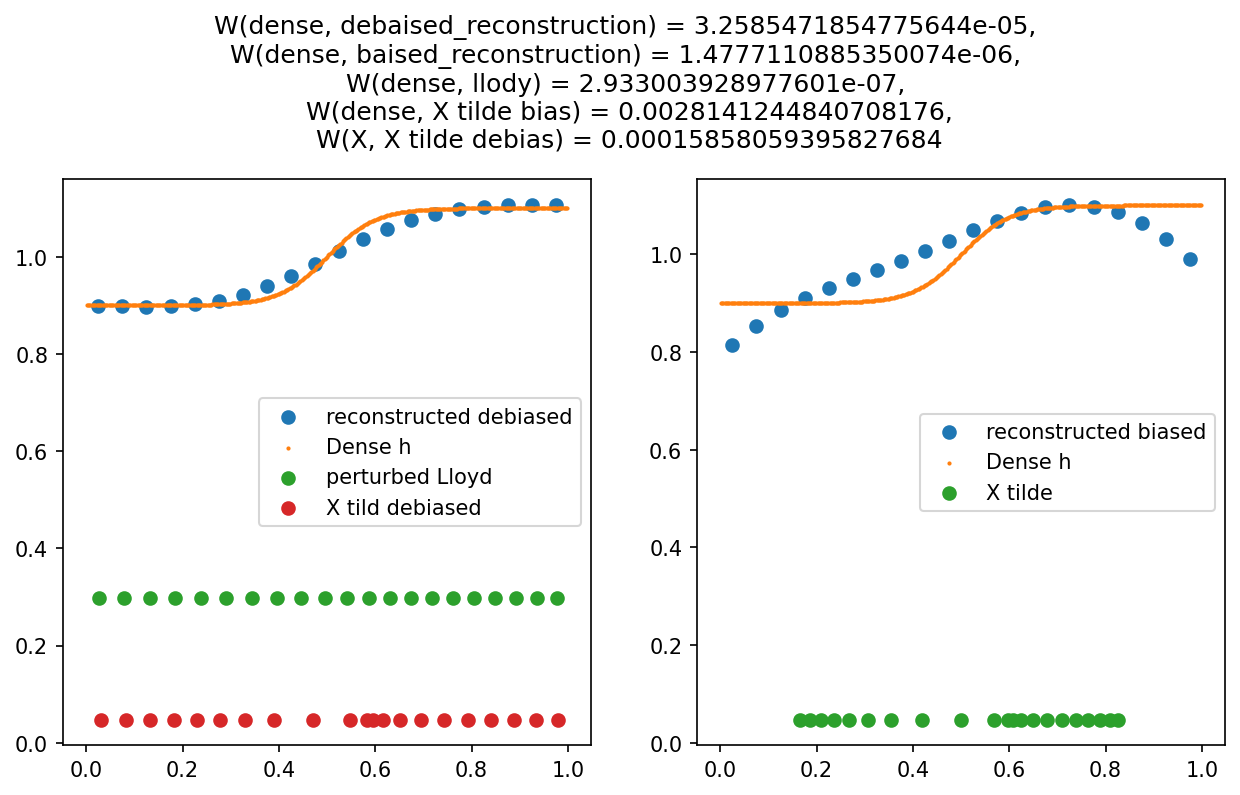

In [ ]:
fig = plt.figure(figsize=(10,5), dpi=150)

ax = fig.add_subplot(121)
ax.scatter(X, h_recon_debiased, label='reconstructed debiased')
ax.scatter(X_dense, h_dense, s=1, label='Dense h')
ax.scatter(Y, np.ones_like(Y)/len(Y) + 0.25, label='perturbed Lloyd')
ax.scatter(X_debiased_tilde, np.ones_like(X_debiased_tilde)/len(X_debiased_tilde), label='X tild debiased')
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(X, h_recon_biased, label='reconstructed biased')
ax.scatter(X_dense, h_dense, s=1, label='Dense h')
ax.scatter(X_tilde, np.ones_like(X_tilde)/len(X_tilde), label='X tilde')
ax.legend()

plt.suptitle(f'W(dense, debaised_reconstruction) = {s_bias},\n W(dense, baised_reconstruction) = {s_debiased}, \n W(dense, llody) = {s_y}, \n W(dense, X tilde bias) = {s_X_bias},\n W(dense, X tilde debias) = {s_X_debiased}', y=1.1)

In [65]:
print(f'Linf error X - Xtild:{np.linalg.norm(X - X_tilde, ord=float("inf"))}')
print(f'Linf error X - Xtild debiased:{np.linalg.norm(X - X_debiased_tilde, ord=float("inf"))}')

ValueError: operands could not be broadcast together with shapes (20,) (21,) 